In [53]:
import pandas as pd
import numpy as np
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

#DISCLAIMER = Data incomplete and graphs require further labelling. Serves as hyptothetical case for useful data
#insights are unlikely validated with confidence


# ACT 1 - CLEANSING 

In [194]:
data_in = pd.read_csv('g_sheet_data.csv')

print ('\nSample\n', data_in.head(), '\n')

print ('Data types', data_in.dtypes, '\n')
#convert string representation of FundingDate to datetime obj
data_in.iloc[:, 2] = pd.to_datetime(data_in.iloc[:,2])
#Empty launchAt datetimes map to NaT
data_in.iloc[:, -1] = pd.to_datetime(data_in.iloc[:, -1],errors='coerce')

# prevelance of NaN
null_positions =  data_in.isnull()
null_counter = pd.DataFrame([{**{'col': c, True : 0, False : 0}, ** dict(null_positions[c].value_counts())} for c in null_positions])
print ('\nNan Prevelance\n', null_counter)

# test for duplicate IDs
if max(dict(data_in.loc[:,'_id'].value_counts()).items(), key = lambda y:y[1])[1] == 1:
#     pass
        print ("\nAll _ids are unique!\n")
        #SUCCESS!
    
#clean variable representations of text
str_cols = data_in.loc[:, ['Location', 'Industry', 'FundingType']]
import json
for co in str_cols:
    out_d = {co : list(str_cols[co].unique())}
    print (json.dumps(out_d, indent = 4))
    #e.g. Real Estate maps to real estate
    
#uniform setting
str_cols = data_in.select_dtypes(include = ['O']).columns
for d in list(str_cols):
    data_in[d] = data_in[d].apply(str.lower)
        
#location counts
location_counts = dict(data_in['Location'].value_counts())
#New York, Kuala Lumpur thrown with 1 and 2 records respectively
data_in = data_in[data_in['Location'].isin(['new york', 'kuala lumpur']) == False]
# print (data_in.shape)


Sample
             _id  FundingAmount               FundingDate FundingType  \
0     230620161          50000  2015-12-31T16:00:00.000Z        seed   
1    2306201611         589000  2012-12-31T16:00:00.000Z        seed   
2    2306201616         150000  2013-12-31T16:00:00.000Z        seed   
3   23062016371         275000  2015-01-26T00:00:00.000Z        seed   
4  230620161016         100000  2013-12-31T16:00:00.000Z        seed   

                Industry   Location                  launchAt  
0            3D Printing  Hong Kong                       NaN  
1            3D Printing  Singapore  2013-04-30T16:00:00.000Z  
2            3D Printing  Hong Kong                       NaN  
3            3D Printing  Singapore  2014-04-30T16:00:00.000Z  
4  Consumer Software/App  Hong Kong  2011-12-31T16:00:00.000Z   

Data types _id               int64
FundingAmount     int64
FundingDate      object
FundingType      object
Industry         object
Location         object
launchAt         

# ACT 2 - Aggregate Graphs

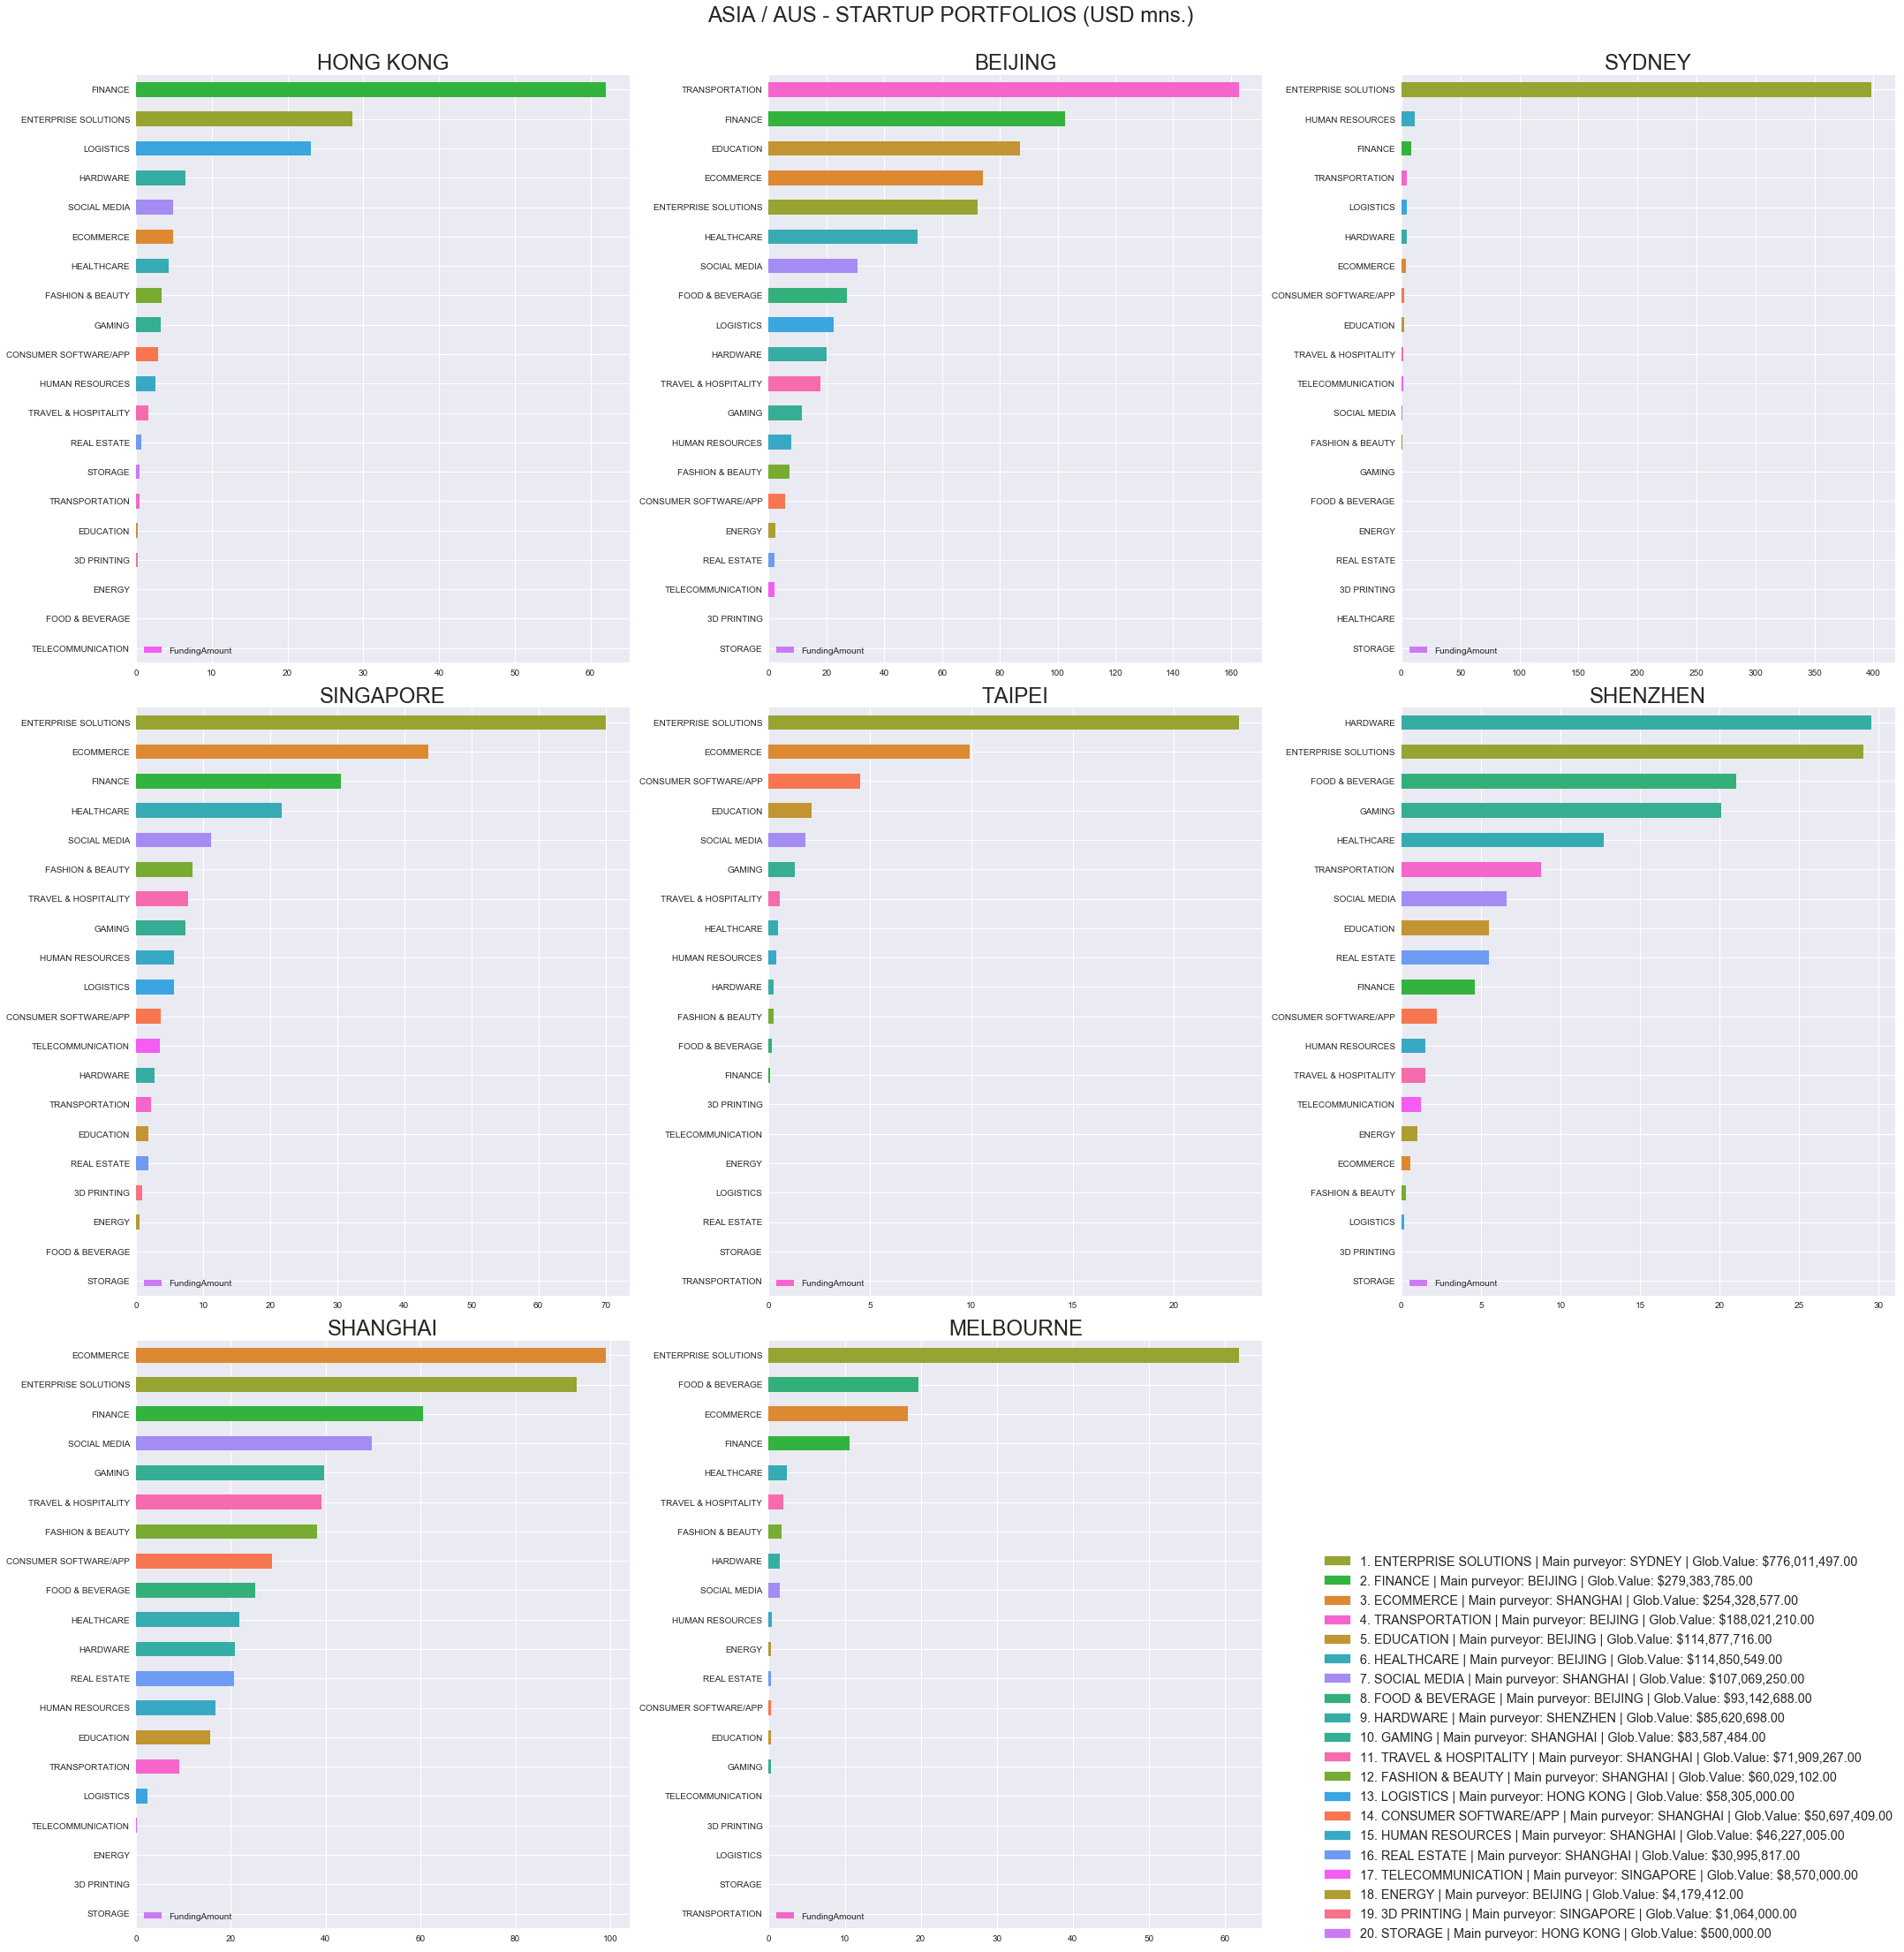

In [192]:
def help_divisor(int_x, divisor, precision = 2):
    val = float(int_x / divisor) 
    return round(val, precision )

def color_scale(col, reverse = False):
    """
    Color gradient descent / ascent
    """
    gradient_rgb = [(x/10.0, x/20.0, 0.75) for x in range(len(average_country_x))]
    if reverse:
        return list(reversed(gradient_rgb))
    else:
        return gradient_rgb
    
def get_fig_row(l, mx_col):
    while len(l) % mx_col != 0:
        l = l + [0]
    return int(len(l) / mx_col)

def get_sub_plot_pos(uniq_vals, max_cols = 3):
    """
    Generate coordinates for subplots
    """
    max_rows = get_fig_row(uniq_vals, max_cols)
    positions = [[(y, x) for  y in range(0, max_rows)] for x in range(0, max_cols)]
    positions = [x for y in positions for x in y]
    return positions, max_rows, max_cols

def autolabel(rects, ax_, label):
    """
    Attach a text label to right of each bar displaying portion of total as a percentage
    """
    for rect in rects:
        width = rect.get_width()
        ax_.text(rect.get_y() + rect.get_height()/2., 1.05*width,
                label,
                ha='center')

#####################################################
    
# TOTAL INVESTMENT / LOCATION - Warm Up # 1

use_cols = ['Location', 'FundingAmount', 'Industry']

# 
# c_nw_cand = data_in.loc[:, use_cols[:2]]
# c_nw_cand['Location'] = c_nw_cand['Location'].apply(str.upper)
# c_nw = c_nw_cand.groupby(['Location']).agg({'FundingAmount' : 'sum'}).sort_values('FundingAmount')
# c_nw.iloc[:, -1] = c_nw.iloc[:, -1].apply(lambda x: help_divisor(x, 1000000))
# cnw_plot = c_nw.plot.barh(title = 'Reg. TOTAL Investment (USD mns)', legend = False, grid = True, color = color_scale(country_net_worth, reverse = True))
# cnw_plot.set_ylabel('')
# plt.show()

#####################################################

# AVG INVESTMENT / LOCATION - Warm up # 2
# avg_cand = data_in[use_cols]
# avg_cand['Location'] = avg_cand['Location'].apply(str.upper)
# avg_inv_c = avg_cand[use_cols[:2]].groupby('Location').mean().add_prefix('mean_')
# avg_inv_c.iloc[:, 0] = avg_inv_c.iloc[:, 0].apply(lambda x: help_divisor(x, 100000))
# avg_inv_c = avg_inv_c.sort_values('mean_FundingAmount', ascending = True)
# avg_inv_plot = avg_inv_c.plot(title = 'Reg. AVG investment (USD mns)',kind = 'barh', legend = False, grid = True, color = color_scale(average_country_x, reverse = True))
# avg_inv_plot.set_ylabel('')
# plt.show()

#####################################################

#STATIC SURVEY 1
#Industry Rankings / Country. 
#Legend sorted by main purveyor and total expenditure across Asia + Aus cities

# 20 color seaborn pallet
c_palette = sns.color_palette("husl", 20)

positions, len_r , len_c = get_sub_plot_pos(list(data_in['Location'].unique()))
fig, axes = plt.subplots(nrows = len_r, ncols = len_c, figsize=(30,30))
c_in_sub = data_in.loc[:, use_cols]
set_of_industries = [x.upper() for x in list(c_in_sub['Industry'].unique())]
set_of_locations = [x.lower() for x in list(c_in_sub['Location'].unique())]
color_attr = dict(zip(set_of_industries, c_palette))

#for global sort order
podium = {}
    
ix = 0
for city in c_in_sub['Location'].unique():
    new_sub = c_in_sub[c_in_sub['Location'] == city].iloc[:, 1:]
    new_sub['Industry'] = new_sub['Industry'].apply(str.upper)
    plot_fig = new_sub.groupby('Industry').agg({'FundingAmount' : 'sum'})
    plot_fig.iloc[:, -1] =  plot_fig.iloc[:, -1].apply(lambda x: help_divisor(x, 1000000))
    #filling non-init industries  
    for ind in set_of_industries:
        if ind not in plot_fig.index.values:
            plot_fig.loc[ind.upper()] = 0
    plot_fig = plot_fig.sort_values(by = 'FundingAmount')
    podium[city] = plot_fig.reset_index()
    axes_pos = list(positions[ix])
    axe_pointer = axes[axes_pos[0], axes_pos[1]]
    plot_fig.plot(kind = 'barh', ax = axe_pointer, color = [color_attr[i] for i in plot_fig.index.values]); axe_pointer.set_title(city.upper(), size = 24); axe_pointer.set_ylabel(''), axe_pointer.set_xlabel('');
    axe_pointer.spines['bottom'].set_visible(False)
    # unable to plot proportion neatly, autolabel function needs tweaking
#     autolabel(axe_pointer.patches, axe_pointer, plot_fig['FundingAmount'].sum() / c_in_sub['FundingAmount'].sum())
    ix += 1

    
fig.suptitle('ASIA / AUS - STARTUP PORTFOLIOS (USD mns.)', fontsize = 24, x = 0.5, y = 1.02)

fig.delaxes(axes[-1, -1])

get_top_performers = [('%s | Main purveyor: %s' % (c, max(list(podium.items()), key = lambda y: list(y[1][y[1]['Industry'] == c]['FundingAmount'])[0])[0].upper()),
                      c_in_sub[c_in_sub['Industry'] == c.lower()]['FundingAmount'].sum()) for c in set_of_industries]
# ranking_top_performers = 
#sort by total investment
sorted_tp = sorted(get_top_performers, key = lambda x: x[1], reverse = True)
#colorized patching based on sort order
legend_patches = [mpatches.Patch(color=color_attr[k[0].split('|')[0].strip()]) for k in list(sorted_tp)]
sorted_tp = [str(ix + 1) + '. ' + ' | '.join([x[0], 'Glob.Value: %s' % '${:,.2f}'.format(x[1])]) for ix, x in enumerate(sorted_tp)]
fig.legend(handles = legend_patches,labels = list(sorted_tp), loc='lower right', fontsize ='x-large')
# #tidying / squaring figures
fig.tight_layout()

#####################################################

# ACT 3 - Time Series

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


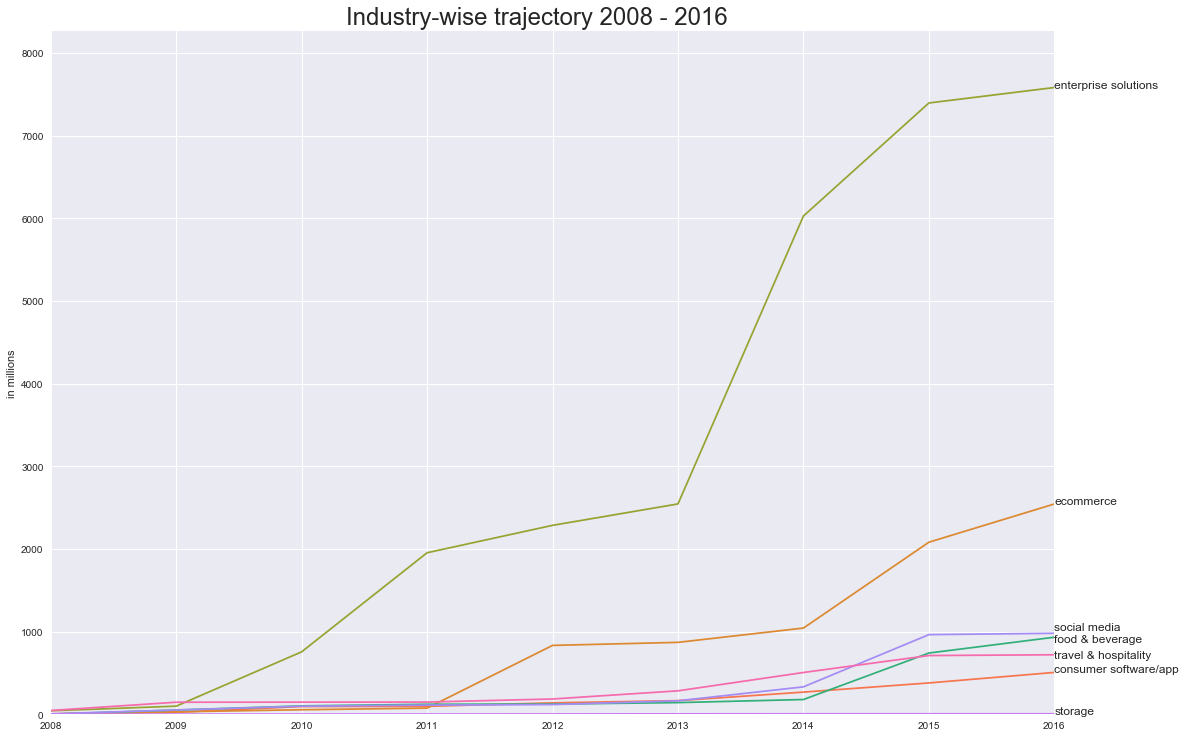

In [225]:
import matplotlib.pyplot as plt


#####################################################

# HISTORIC TRAJECTORY

cols = ['FundingDate', 'FundingAmount', 'Location', 'Industry']
growth_rate = data_in[cols]
growth_rate['Year'] = growth_rate['FundingDate'].apply(lambda x: x.year)
growth_rate = growth_rate.set_index('Year', drop = True)
fig3, ax3 = plt.subplots(1, 1, figsize=(15,10))

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()

ax3.set_xlim(2008, 2016)

ind_totals = []
for s in set_of_industries:
    industry_total = growth_rate[growth_rate['Industry'] == s.lower()]['FundingAmount'].sum()
    ind_totals.append(industry_total)
    
ax3.set_ylim(help_divisor(min(ind_totals), 100000), help_divisor(max(ind_totals), 100000) + 500)
c_palette = sns.color_palette("husl", 20)

growth_rate['FundingAmount'] = growth_rate['FundingAmount'].apply(lambda x: help_divisor(x, 100000))

def c_sum(l):
    from itertools import accumulate
    return list(accumulate(l))


# Displacing labels to avoid overlap
y_offsets = {'social media' : 40, 'food & beverage' : -60, 'travel & hospitality' : -40}
growth_rate = growth_rate[growth_rate.index > 2007]
for ix, ind in enumerate(growth_rate['Industry'].unique()):
    try:
        subset = growth_rate[growth_rate['Industry'] == ind]
        if 2016 not in subset.index.values:
            subset.loc[2016, 'FundingAmount'] = 0
        if 2008 not in subset.index.values:
            # bridging null and positive values results in dropping of several industries in graph
            subset.loc[2008, 'FundingAmount'] = 0
        years = []
        cum_sum = []
        for g_df in subset.groupby(['Year']):
            year, df = g_df
            years.append(year)
            cum_sum.append(df['FundingAmount'].sum())
        cumulative_sum = c_sum(cum_sum) 
        y_offset = cumulative_sum[-1]
        if ind in y_offsets.keys():
            y_offset += y_offsets[ind]
        line = plt.plot(years, cumulative_sum, color = c_palette[ix])
        plt.text(2016, y_offset , ind, fontsize=12)
    except ValueError:
        pass

fig3.suptitle('Industry-wise trajectory 2008 - 2016', fontsize = 24, x = 0.5, y = 1.02)
ax3.set_ylabel('in millions')
fig3.tight_layout()
#IMPROVEMENTS
# Clearer understanding of smoothing



# ACT 4 - Facts + Figures

In [270]:

d = data_in[data_in['launchAt'].isnull() == False].loc[:, ['FundingAmount','FundingDate', 'launchAt', 'FundingType', 'Industry']]
d['difference'] = d.FundingDate - d.launchAt
d.difference = d.difference.apply(lambda x: x.days)

before = d[d.difference < 0]

before_launch = {
    'mask' : 'before launch', 
    'Number of firms' : len(before), 
    'Funding_type_breakdown' : {k:"{0:.2f}%".format(float(v / len(before)) * 100) for k,v in dict(before['FundingType'].value_counts()).items()},
    'Industry break down' : {k: "{0:.2f}%".format(float(v / len(before)) * 100) for k,v in dict(before['Industry'].value_counts()).items()},
    'average investment received' : "$USD {0:.2f}".format(before['FundingAmount'].mean()),
    'average time to launch' : 0,
}

after = d[d.difference > 0]

after_launch = {
    'mask' : 'after launch',
    'Number of firms' : len(after), 
    'Funding_type_breakdown' : {k:"{0:.2f}%".format(float(v / len(after)) * 100) for k,v in dict(after['FundingType'].value_counts()).items()},
    'Industry break down' : {k: "{0:.2f}%".format(float(v / len(after)) * 100) for k,v in dict(after['Industry'].value_counts()).items()},
    'average investment received' : "$USD {0:.2f}".format(after['FundingAmount'].mean()),
    'average time to launch' : "{0:.2f} days".format(after['difference'].mean())
}

print (pd.DataFrame([after_launch, before_launch]))

#INSIGHTS
# Seed funding is most prevelant funding type
# Average time from last round of funding to launch is 728 days.
# Average investment received is 790K +, startups are seemingly all high value 
# Finance and enterprise solutions are consistently most invested industries (time series data endorses)


                              Funding_type_breakdown                                Industry break down  Number of firms average investment received average time to launch           mask
0  {'seed': '64.80%', 'a': '32.54%', 'b': '2.24%'...  {'enterprise solutions': '22.72%', 'finance': ...              713             $USD 3151620.79            727.92 days   after launch
1                  {'seed': '87.61%', 'a': '12.39%'}  {'finance': '19.47%', 'enterprise solutions': ...              113              $USD 790553.56                      0  before launch
